# Generate CandleStick chart using Tick Historical End of Day data

## Overview

This example demonstrates how to use python to request daily end of day data and generate basic graphs and CandleSticks chart for trading analysis. Basically, the [Japanese candlestick chart](https://www.investopedia.com/trading/candlestick-charting-what-is-it/) commonly used to illustrate movements in the price of a financial instrument over time. It's popular in finance and some strategies in technical analysis use them to make trading decisions, depending on the shape, color, and position of the candles.

[Thomson Reuters Tick History (TRTH)](https://developers.refinitiv.com/thomson-reuters-tick-history-trth/thomson-reuters-tick-history-trth-rest-api) is an Internet-hosted product on the DataScope Select platform that provides a REST API for unparalleled access to historical high-frequency data across global asset classes dating to 1996. Python developer can use On-demand request to retrieve End of Day data and then they can use the time series tools available in Python or Pandas to works with the data and generate the candlestick chart and calculate a moving average from the time series data. Note that this example will not cover technical analysis topics.


## Packages Required

This example uses httpclient from Tornado web framework and python JSON library to manage an HTTP request and response message. We also need to use Pandas, Matplotlib and candlestick_ohlc from mpl_finance library to process and visualize the stock data returned from Tick Historical server. We also use a method distplot from seaborn package to plot a simple histogram to see a distribution of the price.

```python
from tornado import httpclient, ioloop
import io
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
from matplotlib.dates import DateFormatter, WeekdayLocator,DayLocator, MONDAY
from mpl_finance import candlestick_ohlc
```

## Implementation 

There are three main steps in this example, starting from using the REST API retrieves the Time Series data and plotting graphs and generate a CandleStick Chart.

* **Step1** Get Access Token from Tick Historical Server.
* **Step2** Use the Access Token to send OnDemand Extraction request to retrieve the end of day data from the server. It will return data buffer containing raw data in CSV format. We need to use time-series tool such as Pandas to get the data and transform it into dataframe.
* **Step3** Visualizing Stock Data by plotting the CandleStick chart from the dataframe and calculate the moving average from the data and plot it to CandleStick chart for technical analysis.


### Get Access Token from DSS Server

Referring to the tutorial from [TRTH REST API tutorial](https://developers.refinitiv.com/thomson-reuters-tick-history-trth/thomson-reuters-tick-history-trth-rest-api/learning?content=8687&type=learning_material_item), to get the access token, we have to send HTTP post message to below endpoint and it needs to send the DSS Username and Password in the request body. 

* Endpoint:

```
https://hosted.datascopeapi.reuters.com/RestApi/v1/Authentication/RequestToken
```

* Method: POST

Headers:
```
Prefer: respond-async
Content-Type: application/json
```

* Body:

```json
{
  "Credentials": {
    "Username": "97xxxx",
    "Password": "XXXXXXX"
  }
}
```
If there is no error happen, it should receive HTTP status code 200. Then we need to parse the Access Token from a response content. There is a JSON data inside response content and we can retrieve the Token from field name **value**. 

* Body:

```json
{
  "@odata.context": "https://hosted.datascopeapi.reuters.com/RestApi/v1/$metadata#Edm.String",
  "value": "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX... XXXXXXXXXXXXXXXXXXXXX"
}
```

The following snippet codes are function GetAuthenticationToken we used to get the access token from the server. It uses AsyncHTTPClient from tornado httpclient to send an HTTP request to TRTH server.


In [1]:
from tornado import httpclient, ioloop
import json
import pandas as pd
import matplotlib.dates as dates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

async def GetAuthenticationToken(username, password):
    http_client = httpclient.AsyncHTTPClient()
    try:

        endpoint = "https://hosted.datascopeapi.reuters.com/RestApi/v1/Authentication/RequestToken"
        _header = {'Prefer': 'respond-async', 'Content-Type': 'application/json; odata.metadata=minimal'}
        _data = {
            'Credentials': {
                'Password': password,
                'Username': username
            }
        }

        print("Send Login request")

        response = await http_client.fetch(endpoint, body=json.dumps(_data), method='POST', headers=_header)

    except Exception as e:
        print("Error: %s" % e)
    else:
        return json.loads(response.body)["value"]

### Retrieve End of Day Time Series data from TRTH Server

This example use step explains in the [REST API Tutorial 7: On Demand End of Day extraction](https://developers.refinitiv.com/thomson-reuters-tick-history-trth/thomson-reuters-tick-history-trth-rest-api/learning?content=11268&type=learning_material_item) to send a request and process response from the server. Below is ExtractRaw function we create to retrieve the TimeSeries data. 

In [2]:
from tornado import httpclient, ioloop
import asyncio
import json
async def ExtractRaw(token, json_payload):
    
    _extractRawURL = "https://hosted.datascopeapi.reuters.com/RestApi/v1/Extractions/ExtractRaw"
    
    # Setup Request Header
    _header = {'Prefer': 'respond-async, wait=5', 'Content-Type': 'application/json; odata.metadata=minimal',
               'Accept-Charset': 'UTF-8', 'Authorization': 'Token' + token}

    # Send HTTP post message to DSS server using extract raw endpoint
    #if you have pyCurl installed please uncomment below line of codoes to use libCurl setting instead.
    #See https://www.tornadoweb.org/en/stable/httpclient.html#
    #httpclient.AsyncHTTPClient.configure("tornado.curl_httpclient.CurlAsyncHTTPClient")
    
    http_client = httpclient.AsyncHTTPClient(request_timeout=60)   
    
    try:
        response = await http_client.fetch(_extractRawURL, body=json.dumps(json_payload), 
                                           method='POST',headers=_header)
    except Exception as e:
        print("Error: %s" % e)
        return None
    else:
        print("\nExtraction Request Sent")
    
    #If http response code is 202 we need to get location from header and run a loop 
    # to query report status until we get reponse status code 200.
    
    if response.code == 202:
            _location = str.replace(response.headers['Location'], "http://", "https://")
            print("Location=", _location)
            from time import sleep
            while True:
                try:
                    #If you experience request timeout you might need to increase request timeout value by
                    #add request_timeout=<new value> to http_client.fetch() functiion.
                    print("Get query status from ",_location)
                    response = await http_client.fetch(_location, method='GET',
                                                       headers=_header)                   
                    if response.code == 200:
                        break
                    else:
                        print("Status:" + str(response.headers['Status']))

                    # Wait for 10 sec and re-request the status to check if it already completed
                    # Actually the document recommends wait time is around 30 sec, we just change it to 2 sec because 
                    # we believe that it should not take a long time to query around 23 year End of Day which should not return row count over 8xxx.
                    # If you change the query to request high-frequency data, you should increase sleep times or use 30 sec otherwise it may add more load to the server.
                except httpclient.HTTPError as e:
                    # HTTPError is raised for non-200 responses; the response
                    # can be found in e.response.
                    print("Error: " + str(e))
                except Exception as e:
                    # Other errors are possible, such as IOError.
                    print("Error: " + str(e))
               
                    
                await asyncio.sleep(20)  
            
    if response.code != 200:
        return None

    json_resp = json.loads(response.body)
    _jobID = json_resp.get('JobId')
    print("Status is completed the JobID is " + str(_jobID) + "\n")

    # Check if the response contains Notes.If the note exists print it to console.
    if len(json_resp.get('Notes')) > 0:
        print("Notes:\n======================================")
        for var in json_resp.get('Notes'):
            print(var)
        print("======================================\n")

    # Request should be completed then Get the result by passing jobID to RAWExtractionResults URL
    _getResultURL = str("https://hosted.datascopeapi.reuters.com/RestApi/v1/Extractions/RawExtractionResults(\'" + _jobID + "\')/$value")
    print("\nRetrieve data from " + _getResultURL)
    response = await http_client.fetch(_getResultURL, method='GET',
                                       headers=_header)
    import io
    df = pd.read_csv(io.BytesIO(response.body), index_col="Trade Date",parse_dates=True)
    assert isinstance(df, pd.DataFrame)
    print("Retrieve data completed")
    return df


There is the main function user can pass JSON request message to the method. Below is snippet codes for the main function and eodRequest contains the json request body. We need Trade Date, Open, High, Low and Last/Close to generate the CandleStick chart. You have to change dss_Username and dss_Password to your DSS username and password. Also change ricname to the RIC you are interesting.

In [3]:
from tornado import httpclient, ioloop
import json
from datetime import datetime

dss_Username = "<DSS_USERNAME>"
dss_Password = "<DSS_PASSWORD>"
ricname = "MSFT.O"
startDate ="1996-01-01"
endDate = datetime.now().strftime("%Y-%m-%d")
async def main():
    reqToken = await GetAuthenticationToken(dss_Username,dss_Password )
    print("Request Token=", reqToken)
    eodRequest = {
        "ExtractionRequest": {
            "@odata.type": "#ThomsonReuters.Dss.Api.Extractions.ExtractionRequests.ElektronTimeseriesExtractionRequest",
            "ContentFieldNames": [
                "Instrument ID",
                "Open",
                "High",
                "Low",
                "Last",
                "Volume",
                "Trade Date"
            ],
            "IdentifierList": {
                "@odata.type": "#ThomsonReuters.Dss.Api.Extractions.ExtractionRequests.InstrumentIdentifierList",
                "InstrumentIdentifiers": [
                    {"Identifier": ricname, "IdentifierType": "Ric"}
                ]
            },
            "Condition": {
                "ReportDateRangeType": "Range",
                "QueryStartDate": startDate,
                "QueryEndDate": endDate 
            }
        }
    }
    df= await ExtractRaw(reqToken, eodRequest)
    assert isinstance(df, pd.DataFrame)
    return df

To run the main function. You have to set a valid dss_Username and dss_Password in the sample codes and please make sure that you have permission to use ElektronTimeSeriesExtractionRequest. You can modify ricName,startDate and endDate variables to match your need.

In [4]:
dataframe=await main()

Send Login request
Request Token= _42VU6GCVgWtMTU288UO8AcBuPoXVy0tP17SdbhhppShbfAZd4cKv95-1sh1GYQuttx20HpKh71bHtXi0oc9ZPotMTk_Lk7NMaQI6fME6jnHmzKlC1_pibrGZUeUFOF9iNqUJ3MF7LcQTGWbO7zn2hVKQluo9ChR7RqFyrmdXVR8inDX7r534y8zZ58LObci0VTvlCo-You7Hq2E6_8RdhsEwEAgTaBAF2DGG28zvpj70dL65Ugi-p6nrwSXIefzliFLOackOij-mQ-QkFjQrk07qnDzwky8JbSsshjO8M9M

Extraction Request Sent
Location= https://hosted.datascopeapi.reuters.com/RestApi/v1/Extractions/ExtractRawResult(ExtractionId='0x06c450953210e7e6')
Get query status from  https://hosted.datascopeapi.reuters.com/RestApi/v1/Extractions/ExtractRawResult(ExtractionId='0x06c450953210e7e6')
Status is completed the JobID is 0x06c450953210e7e6

Notes:
Extraction Services Version 13.1.40889 (ec84d57d2aa3), Built Aug  9 2019 18:16:12
Processing started at 27-08-2019 14:57:17.
User ID: 9XXXX
Extraction ID: 2000000096546426
Schedule: 0x06c450953210e7e6 (ID = 0x0000000000000000)
Input List (1 items):  (ID = 0x06c450953210e7e6) Created: 27-08-2019 14:57:17 Last Modifie

We are now getting the End of Day data and then we will create a new dataframe by copy columns Open, High, Low, Last from original dataframe returned from TRTH server and then pass it to our function to generate graph/chart. We need to verify the data by printing head and tail of the dataframe to see the data. And next step we will use the data to plotting graphs and general a CandleStick Chart.

In [5]:
%matplotlib notebook
df = dataframe[['Open', 'High', 'Low','Last','Volume']].copy()
print(len(df.index))
print(df.head(10))
print(df.tail(10))

5954
              Open    High     Low     Last    Volume
Trade Date                                           
1996-01-02  87.875  89.750  87.375  89.7500   3611200
1996-01-03  89.125  90.125  86.750  86.8750   3928600
1996-01-04  87.250  87.500  84.875  87.3750   6397100
1996-01-05  86.250  87.625  86.125  86.3750   3880200
1996-01-08  86.500  87.625  86.125  86.2500    711100
1996-01-09  86.000  86.000  79.875  80.1875  11089000
1996-01-10  80.500  83.250  80.375  82.3750  11348400
1996-01-11  83.500  86.875  83.125  86.6250   7288500
1996-01-12  86.500  86.875  83.875  85.7500   5034000
1996-01-15  85.875  85.875  81.875  82.5000   5285700
                Open      High      Low    Last    Volume
Trade Date                                               
2019-08-13  136.0500  138.8000  135.000  138.60  25496593
2019-08-14  136.3600  136.9200  133.670  133.98  32527251
2019-08-15  134.3900  134.5800  132.250  133.68  28125416
2019-08-16  134.8800  136.4600  134.720  136.13  25026151

## Visualizing Stock Data

## Plot a simple Daily Closing Price line graph

We can create a simple line graph to compare open and close price using the following codes. You can change size of figure.figsize to adjust chart size.


<IPython.core.display.Javascript object>


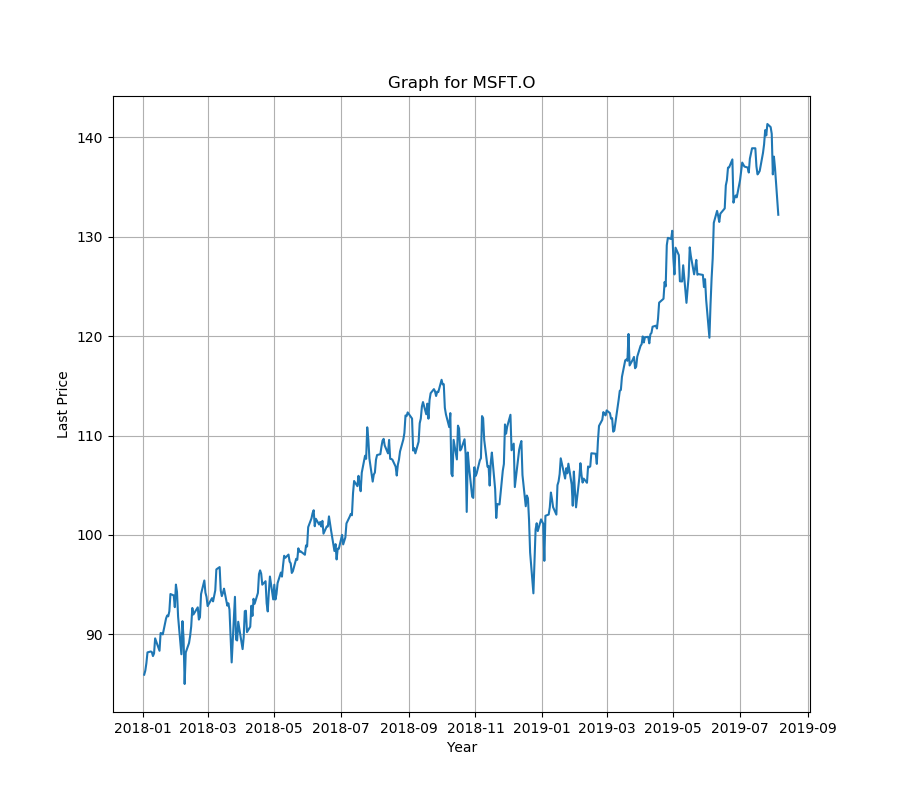

In [15]:
import matplotlib.pyplot as plt

%matplotlib notebook

fig = plt.figure(figsize=(9,8),dpi=100)
ax = plt.subplot2grid((3,3), (0, 0), rowspan=3, colspan=3)
titlename='Graph for '+ricname
ax.set_title(titlename)
ax.set_xlabel('Year')
ax.set_ylabel('Last Price')
ax.grid(True)
dfPlot=df.loc['2018-01-01':'2019-08-05',:]
ax.plot(dfPlot.index, dfPlot['Last']) 
plt.show()

### Plot the Daily Closing Price and Stock Volume

It may useful to review a trading volume to spot for spikes in trading. We can add a bar chart under the line graph for a daily close price as a subplot to indicate the volume. I will shorten a period of time to display data from 2018 instead. You can change it to any period of time you are interesting.

<IPython.core.display.Javascript object>


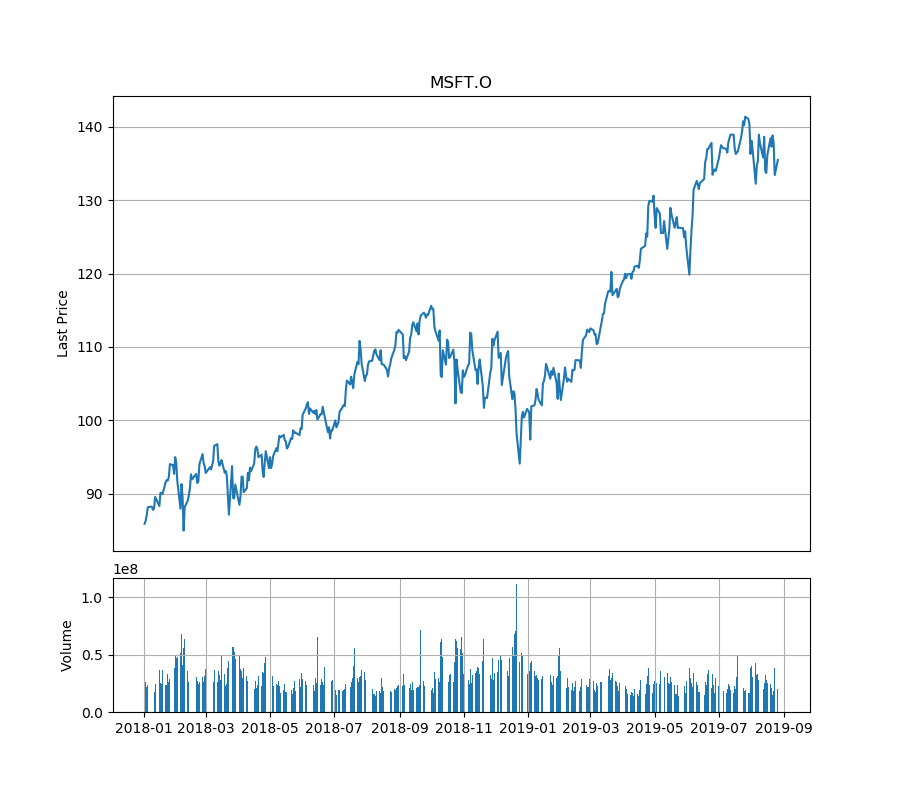

Text(0, 0.5, 'Volume')

In [14]:
import matplotlib.pyplot as plt

dfPlot=df[['Last','Volume']].loc['2018-01-01':datetime.now(),:]

fig = plt.figure(figsize=(9,8),dpi=100)
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.grid(True)

#set sharex to top so we can zoom or pan both graph
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4,sharex=top)
bottom.grid(True)

#top graph for daily close price and bottom one is bar graph for stock volumen.
top.plot(dfPlot.index, dfPlot['Last']) 
bottom.bar(dfPlot.index, dfPlot['Volume']) 
 
# set the labels
top.axes.get_xaxis().set_visible(False)
top.set_title(ricname)
top.set_ylabel('Last Price')
bottom.set_ylabel('Volume')

### Generate a Histogram of the Daily Closing Price

A histogram might be useful to help review daily closing prices over time to see the spread or volatility, and also the type of distribution. We use the seaborn distplot method to plot the graph.


<IPython.core.display.Javascript object>


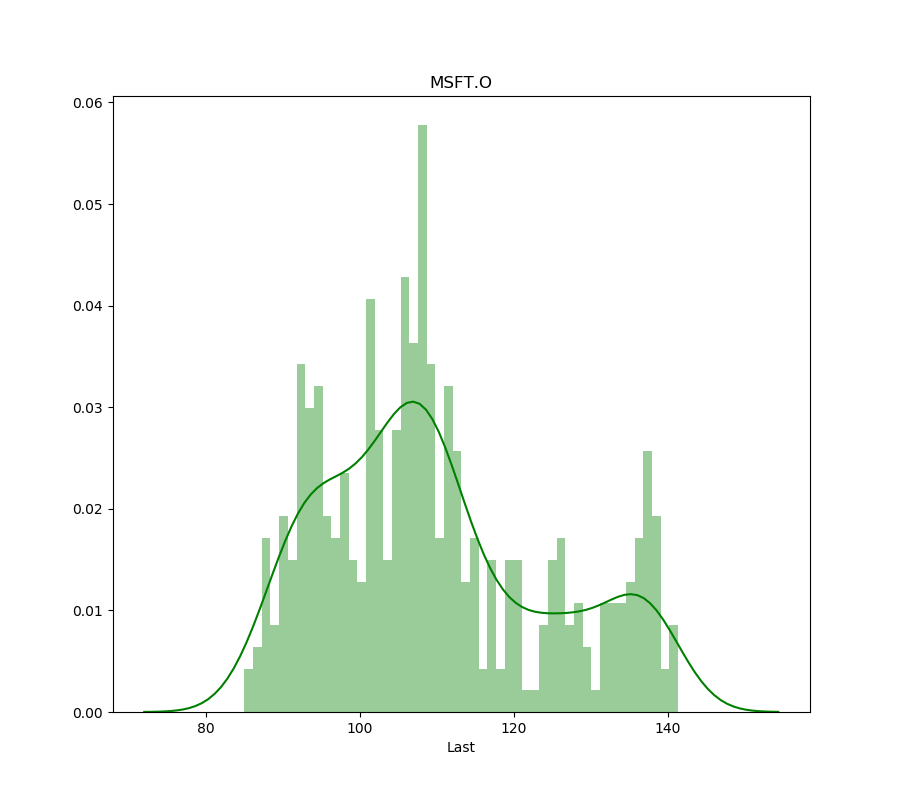

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9,8),dpi=100)
dfPlot=df[['Last','Volume']].loc['2018-01-01':datetime.now(),:]
graph=sns.distplot(dfPlot['Last'].dropna(), bins=50, color='green')
graph.set_title(ricname)
plt.show()

## Plot the CandleStick OHLC Chart

Next step we will generate a CandleStick using method candlestick_ohlc from mpl_finance library. Please note that from details in this [link](https://matplotlib.org/api/finance_api.html), module matplotlib.finance is deprecated in 2.0 and has been moved to a module called mpl_finance. It's still working when we have matplotlib version 2.1.2 but this may stop working in any future releases, however, you still be able to use mpl_finance module to use this feature. Note that mpl_finance is no longer maintained.  

To generate the graph we need to pass a dataframe column which contain Open, High, Low and Last/Close price to the method. And there are some additional steps to configuring a tick locating and formatting before plotting the graph. Hence we will add these steps to a new function instead so it can do formatting and generating a graph and then we can re-use this function to plot a moving average later.

In [9]:
import numpy as np
from matplotlib.dates import DateFormatter, WeekdayLocator,DayLocator, MONDAY
import matplotlib.dates as dates
from mpl_finance import candlestick_ohlc

def pandas_candlestick_ohlc(dat, otherseries = None,item_name=None):
    
    mondays = WeekdayLocator(MONDAY)    
    alldays = DayLocator()        
    dayFormatter = DateFormatter('%d') 
    
    plotdat = dat.loc[:,["Open", "High", "Low", "Last"]]
    stick=1

    fig = plt.figure(figsize=(10,8),dpi=100)
    top=plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
    bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4,sharex=top)

    fig.subplots_adjust(bottom=0.2)
    
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('366 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        top.xaxis.set_major_locator(mondays)
        top.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
        
    top.xaxis.set_major_formatter(weekFormatter)
    top.set_title(item_name)
    bottom.grid(True)
    
    # Create the candelstick chart
    candlestick_ohlc(top, list(zip(list(dates.date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Last"].tolist())),
                      colorup = "green", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = top, lw = 1.3, grid = True)
 
    top.xaxis_date()
    top.autoscale_view()
    top.grid(True)
    #top.set_ylabel("Price")
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    top.axes.get_xaxis().set_visible(False)
   
    bottom.bar(dat.index, dat['Volume'])
    bottom.set_ylabel('Volume')
    plt.show()

We need to call pandas_candlestick_ohlc function and pass a dataframe from previous step to generate a CandleStick chart.
Since we add __%mathplotlib notebook__ to the codes, it will show toolbar under the chart so you can zoom and pan the CandleStick chart. And you can also change start and end date in df_adjustOHLC.loc[] to see a graph in difference peroid of times.

<IPython.core.display.Javascript object>


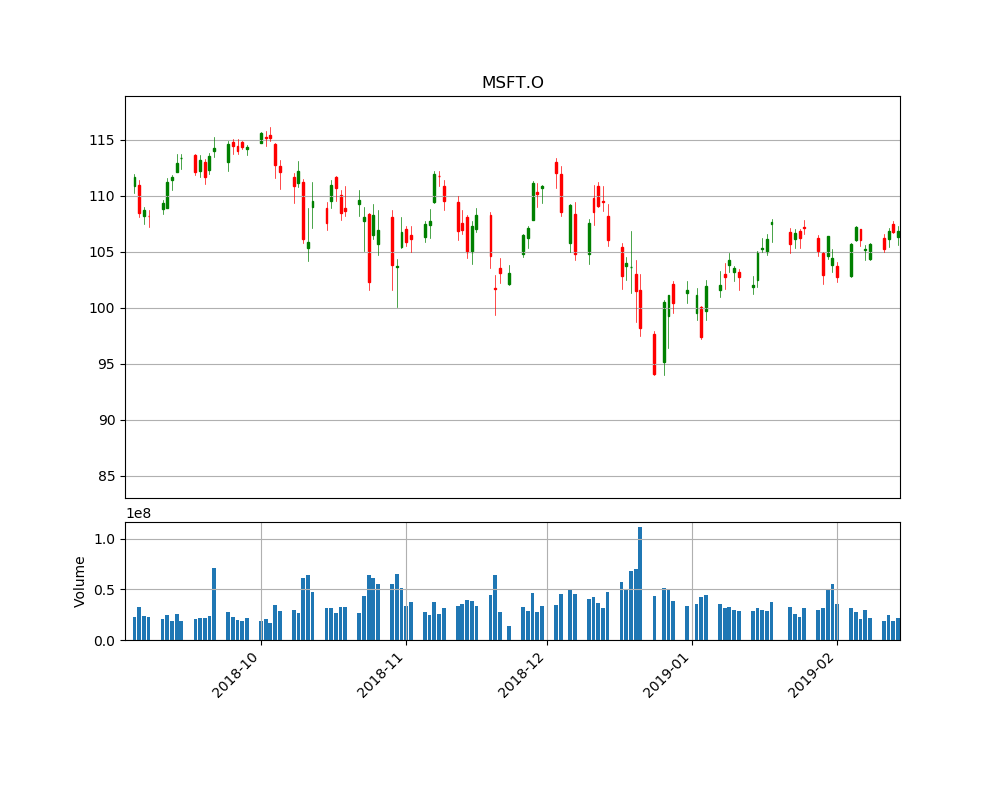

In [17]:
%matplotlib notebook

dfPlot=df.loc['2018-01-01':datetime.now(),:]
pandas_candlestick_ohlc(dfPlot,item_name=ricname)

From a candlestick chart(zoom the graph), a green candlestick indicates a day where the closing price was higher than the open(Gain), while a red candlestick indicates a day where the open was higher than the close (Loss). The wicks indicate the high and the low, and the body the open and close (hue is used to determine which end of the body is open and which the close). You can change the color in pandas_candlestick_ohlc function we have created. And as I said previously, a user can use Candlestick charts for technical analysis and use them to make trading decisions, depending on the shape, color, and position of the candles. We will not cover a technical analysis in this example.

## Add Simple Moving Average to the graph

Lastly, we will add a moving average (MA) to the CandleStick chart. MA is a widely used indicator in technical analysis that helps smooth out price action by filtering out the “noise” from random short-term price fluctuations. It is a trend-following or lagging, indicator because it is based on past prices. The two basic and commonly used moving averages are the simple moving average (SMA), which is the simple average of a security over a defined number of time periods, and the exponential moving average (EMA), which gives greater weight to more recent prices. Note that this example will use only SMA. The most common applications of moving averages are to identify the trend direction and to determine support and resistance levels. After we get the CandleStick chart, it's time to calculate Moving averages and plot to the CandleSticks graph.

Basically, pandas provides functionality for easily computing a simple moving averages. The following codes creating a 20-day moving average from adjusted close price from the data frame, and plotting it alongside the stock.

<IPython.core.display.Javascript object>


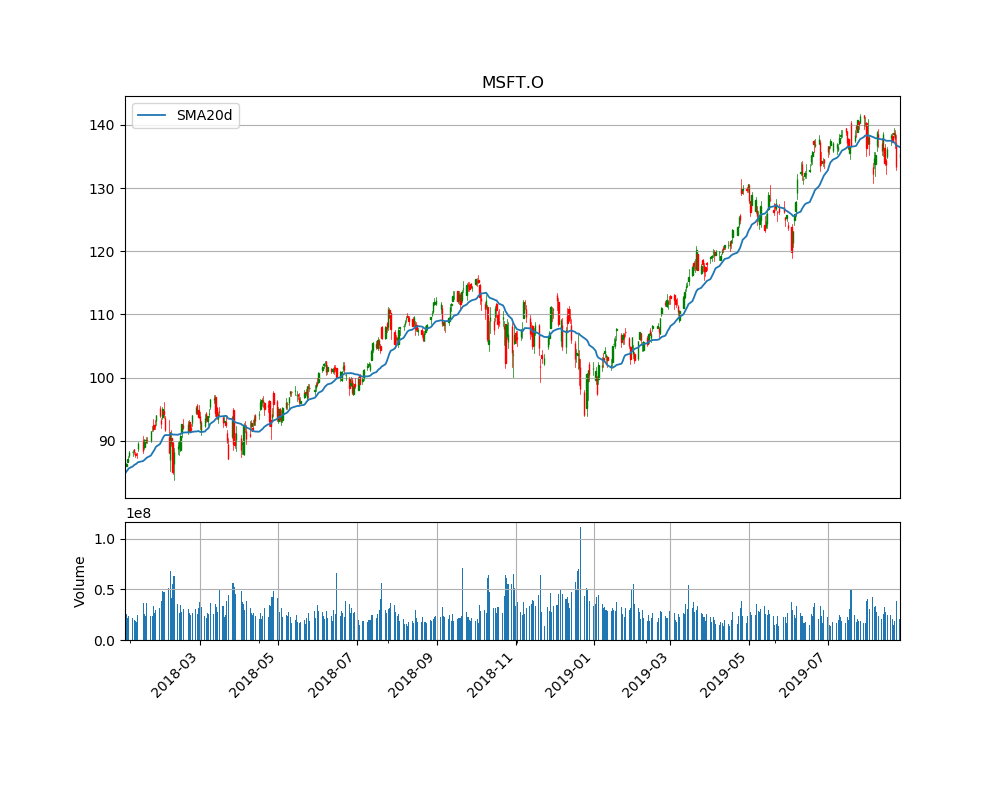

In [11]:
import numpy as np
df["SMA20d"] = np.round(df["Last"].rolling(window = 20, center = False).mean(), 2)
dfPlot=df.loc['2018-01-01':datetime.now(),:]
pandas_candlestick_ohlc(dfPlot, otherseries = "SMA20d",item_name=ricname)

Moving averages lag behind current price action because they are based on past prices; the longer the time period for the moving average, the greater the lag. Thus, a 200-day MA will have a much greater degree of lag than a 20-day MA because it contains prices for the past 200 days.

The length of the moving average to use depends on the trading objectives, with shorter moving averages used for short-term trading and longer-term moving averages more suited for long-term investors. The 50-day and 200-day MAs are widely followed by investors and traders, with breaks above and below this moving average considered to be important trading signals.

The following codes use to generated CandleStick chart with multiple periods of times for SMA (20-day,50-day,75-day, and 200-day).

<IPython.core.display.Javascript object>


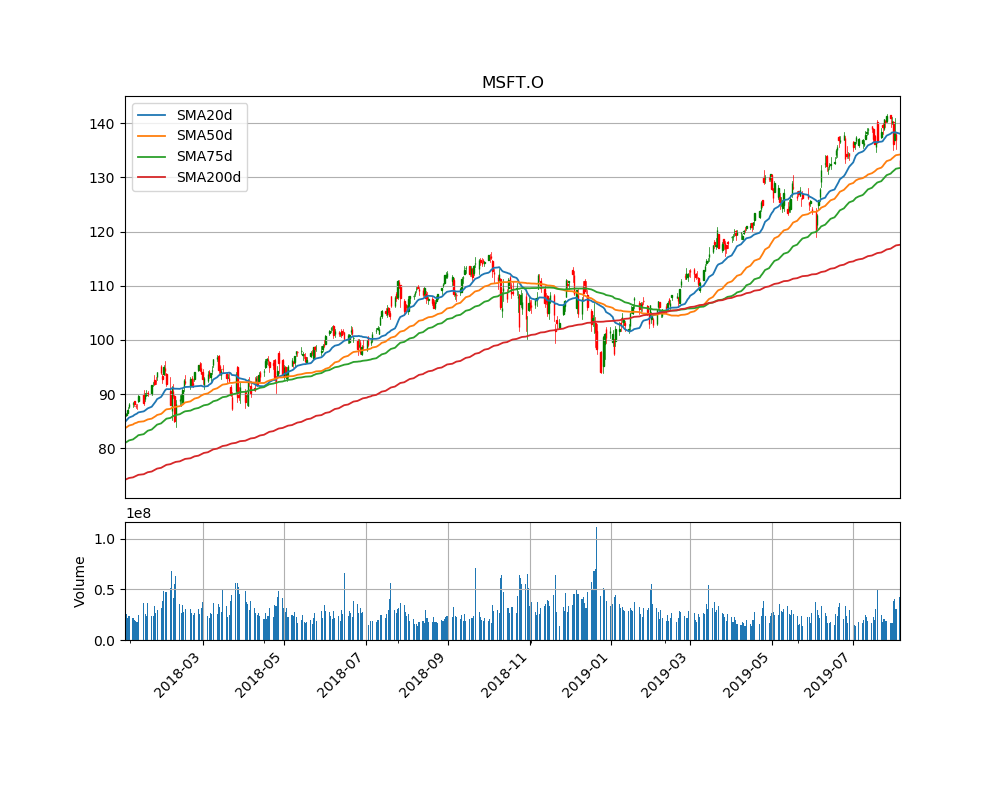

In [12]:
import numpy as np
df["SMA20d"] = np.round(df["Last"].rolling(window = 20, center = False).mean(), 2)
df["SMA50d"] = np.round(df["Last"].rolling(window=50, center = False).mean(), 2)
df["SMA75d"] = np.round(df["Last"].rolling(window=75, center = False).mean(), 2)
df["SMA200d"] = np.round(df["Last"].rolling(window=200, center = False).mean(), 2)
dfPlot=df.loc['2018-01-01':'2019-08-05',:]
dfPlot.reindex()
pandas_candlestick_ohlc(dfPlot, otherseries = ["SMA20d","SMA50d","SMA75d","SMA200d"],item_name=ricname)

There are other types of Moving Average that user can apply with the dataframe to calculate the average value. Many of python open-source package provide the method to calculate MA and [Ta-Lib](https://mrjbq7.github.io/ta-lib/) is one of the libraries which support the calculation and you may try it with the data from the Eikon Data API. However, we do not cover in this example.

## Summary

This example provides a step to use Python to retrieve an End of Day Time Series data from Tick Historical Server and plot the data on various kind of graph. It also provides a sample function to plot a CandleStick chart with a moving average for technical analysis. User can add their own codes/algorithm and modify the function to generate a chart to match their requirement and may use an external library to calculate the moving average and plot to the chart. The graphs should be useful in terms of fundamental stock price technical analysis. The user can use the graphs/chart to identify trading opportunities in price trends and patterns seen on charts. 

## References

* [Thomson Reuters Tick History (TRTH)](https://developers.refinitiv.com/thomson-reuters-tick-history-trth/thomson-reuters-tick-history-trth-rest-api)
* [Tornado Web Framework](https://www.tornadoweb.org/en/stable/guide.html)
* [CandleStick chart what is it?](https://www.investopedia.com/trading/candlestick-charting-what-is-it/)
* [What Is a Moving Average Article.](https://www.investopedia.com/terms/m/movingaverage.asp)
* [Seborn Tutorial](https://seaborn.pydata.org/tutorial/distributions.html)